In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics

#load dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('../dataset/incident_profile_95_cleaned.csv')
df.columns.sort_values()

Index(['AGE_GROUP_15_26', 'AGE_GROUP_26_33', 'AGE_GROUP_33_43',
       'AGE_GROUP_43_55', 'AGE_GROUP_55_104', 'BEAT_OF_OCCURRENCE',
       'CRASH_MONTH', 'CRASH_YEAR', 'adverse_weather_crash_rate', 'avg_age',
       'avg_crash_severity_score', 'avg_lighting_severity',
       'avg_responsibility_score', 'avg_roadway_severity',
       'avg_weather_severity', 'combined_weather_road_severity',
       'damage_cost_LB', 'damage_high', 'damage_low', 'damage_medium',
       'damage_severity_avg', 'fatality_rate', 'injury_severity_score',
       'monthly_total_units', 'neo_patented_drivers', 'night_crash_rate',
       'num_towed_units_LB', 'pct_neo_patented_drivers', 'pct_senior_drivers',
       'road_defect_crash_rate', 'senior_drivers', 'severe_injury_rate',
       'speeding_influence', 'sum_category_motorcycle',
       'sum_category_off-road/specialized', 'sum_category_passenger vehicle',
       'sum_category_public transport', 'sum_category_truck/commercial',
       'sum_damage_category_hig

In [ ]:
#dbscan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

selected_features = ['avg_crash_severity_score', 'avg_lighting_severity', 'combined_weather_road_severity', 'fatality_rate', 'speeding_influence', 'damage_cost_LB']

plt.figure(figsize=(20, 20))
sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [4]:
scaler_ss = StandardScaler()
df_cluster_ss = scaler_ss.fit_transform(df[selected_features])
df_cluster_ss = pd.DataFrame(df_cluster_ss, columns=df[selected_features].columns)
df_cluster_ss.head()

avg_crash_severity_score  avg_lighting_severity  \
0                 -0.594719               0.440448   
1                  0.702175              -0.714096   
2                 -1.384838               0.246690   
3                  0.021122               0.232783   
4                 -0.388483              -0.290854   

   combined_weather_road_severity  fatality_rate  speeding_influence  \
0                        0.528371      -0.169046            0.421623   
1                       -0.628140      -0.169046            0.178818   
2                        0.039103      -0.169046            0.237913   
3                        0.726945      -0.169046            2.777173   
4                        0.737382      -0.169046           -0.599440   

   damage_cost_LB  
0        0.775171  
1       -0.255078  
2       -0.934107  
3        3.748847  
4        1.126393

In [7]:
from sklearn.neighbors import NearestNeighbors

k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(df_cluster_ss)

distances, indices = nbrs.kneighbors(df_cluster_ss)
distances = np.sort(distances, axis=0)
distances = distances[:, k-1]

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title(f'k = {k}')
plt.ylim([0, 3])
plt.axhline(y=1, color='r', linestyle='--')
plt.show()


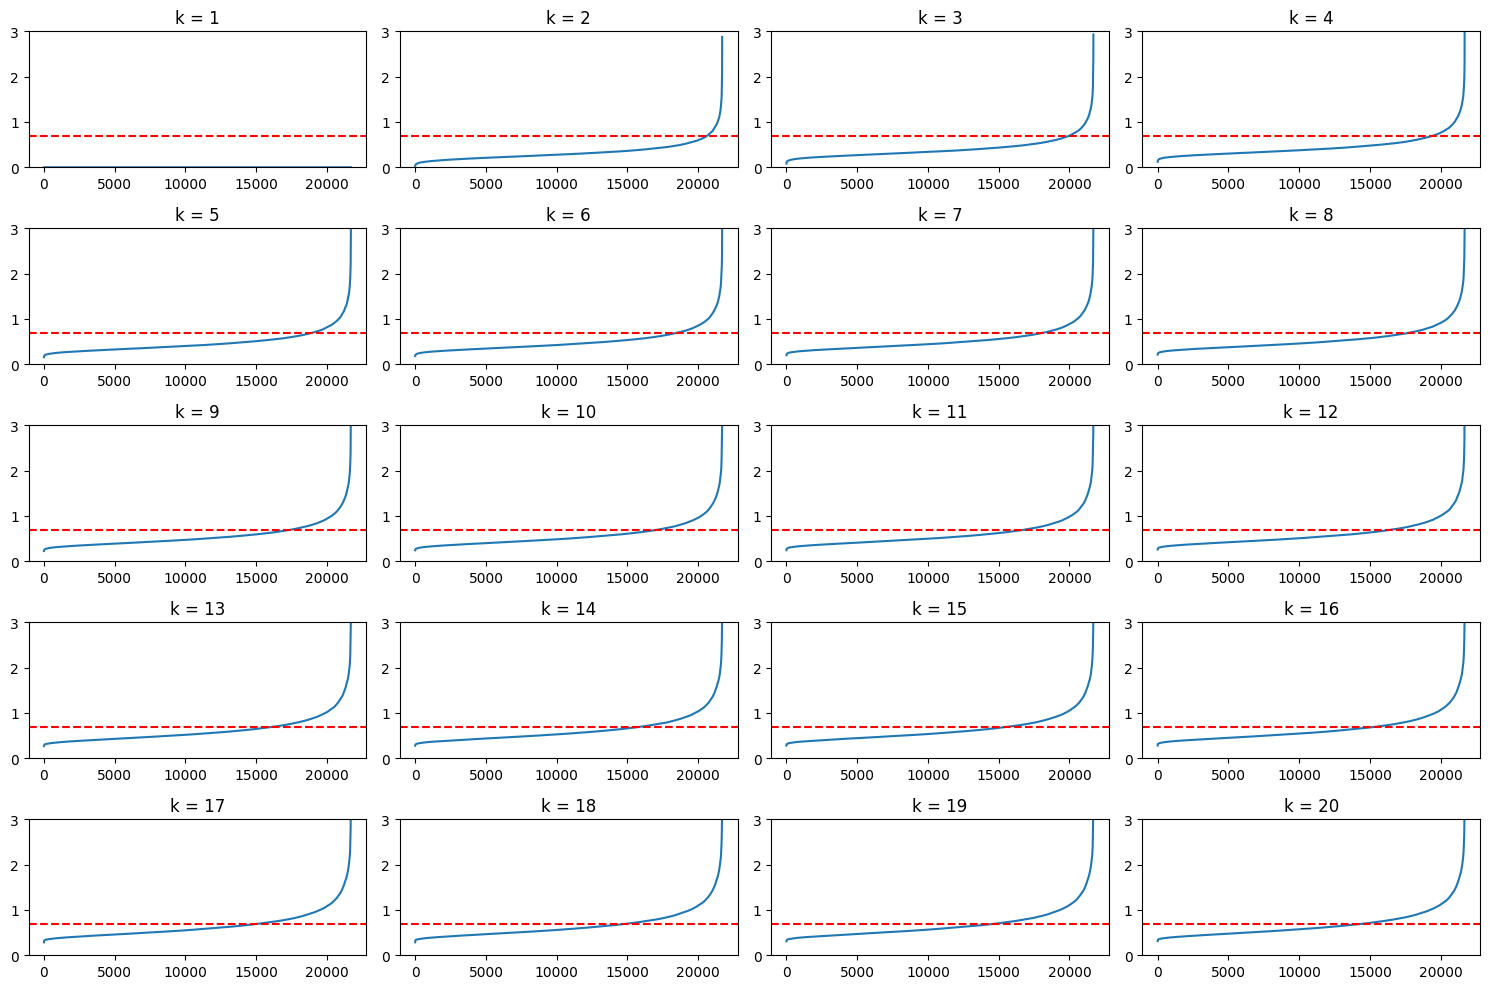

In [41]:
from sklearn.neighbors import NearestNeighbors

max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_cluster_ss)

fig , ax = plt.subplots(5, 4, figsize=(15,10))

for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_cluster_ss)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 3])
    ax[k//4, k%4].axhline(y=0.7, color='r', linestyle='--')
    
plt.tight_layout()
plt.show()

## We perform a Grid search with min_samples from 5 to 15 and eps from 0.7 to 1.7

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm

best_score = -1
best_min_samples = None
best_eps = None

min_samples_range = range(5, 15)

eps_range = np.arange(0.7, 1.7, 0.05)

scores = []

for min_samples in tqdm(min_samples_range, desc="min_samples"):
    for eps in tqdm(eps_range, desc="eps", leave=False):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_cluster_ss)
        
        score = silhouette_score(df_cluster_ss, labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if(n_clusters > 1):
            scores.append((score, min_samples, eps,n_clusters))
            
        
scores.sort(reverse=True, key=lambda x: x[0])

#put scores in a csv
scores_df = pd.DataFrame(scores, columns=['score', 'min_samples', 'eps','n_clusters'])
scores_df.to_csv('dbscan_scores10.csv', index=False) 

scores_df.head(10)

min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

min_samples: 100%|██████████| 10/10 [50:28<00:00, 302.80s/it]


score  min_samples   eps  n_clusters
0  0.543736            5  1.55           2
1  0.531087            6  1.40           2
2  0.521551            5  1.40           2
3  0.518407            5  1.25           2
4  0.512666           14  1.25           2
5  0.501206            9  1.15           2
6  0.462137            6  1.05           2
7  0.460246           12  1.10           2
8  0.459981           11  1.10           2
9  0.459694           12  1.15           2

In [9]:
dbscan = DBSCAN(eps=0.9, min_samples=9)
labels = dbscan.fit_predict(df_cluster_ss)
df['cluster'] = labels
df['cluster'].value_counts()

cluster
 0    20489
-1     1071
 1       96
 2       19
 3       15
Name: count, dtype: int64

## Silhouette Score

In [10]:
silhouette_score(df_cluster_ss, labels)

np.float64(0.3924866521198125)

### Separation with davies_bouldin_score (Lower value = better clustering)

In [11]:
print('Separation %s' % metrics.davies_bouldin_score(df_cluster_ss, labels)) 

Separation 1.8193928295217738


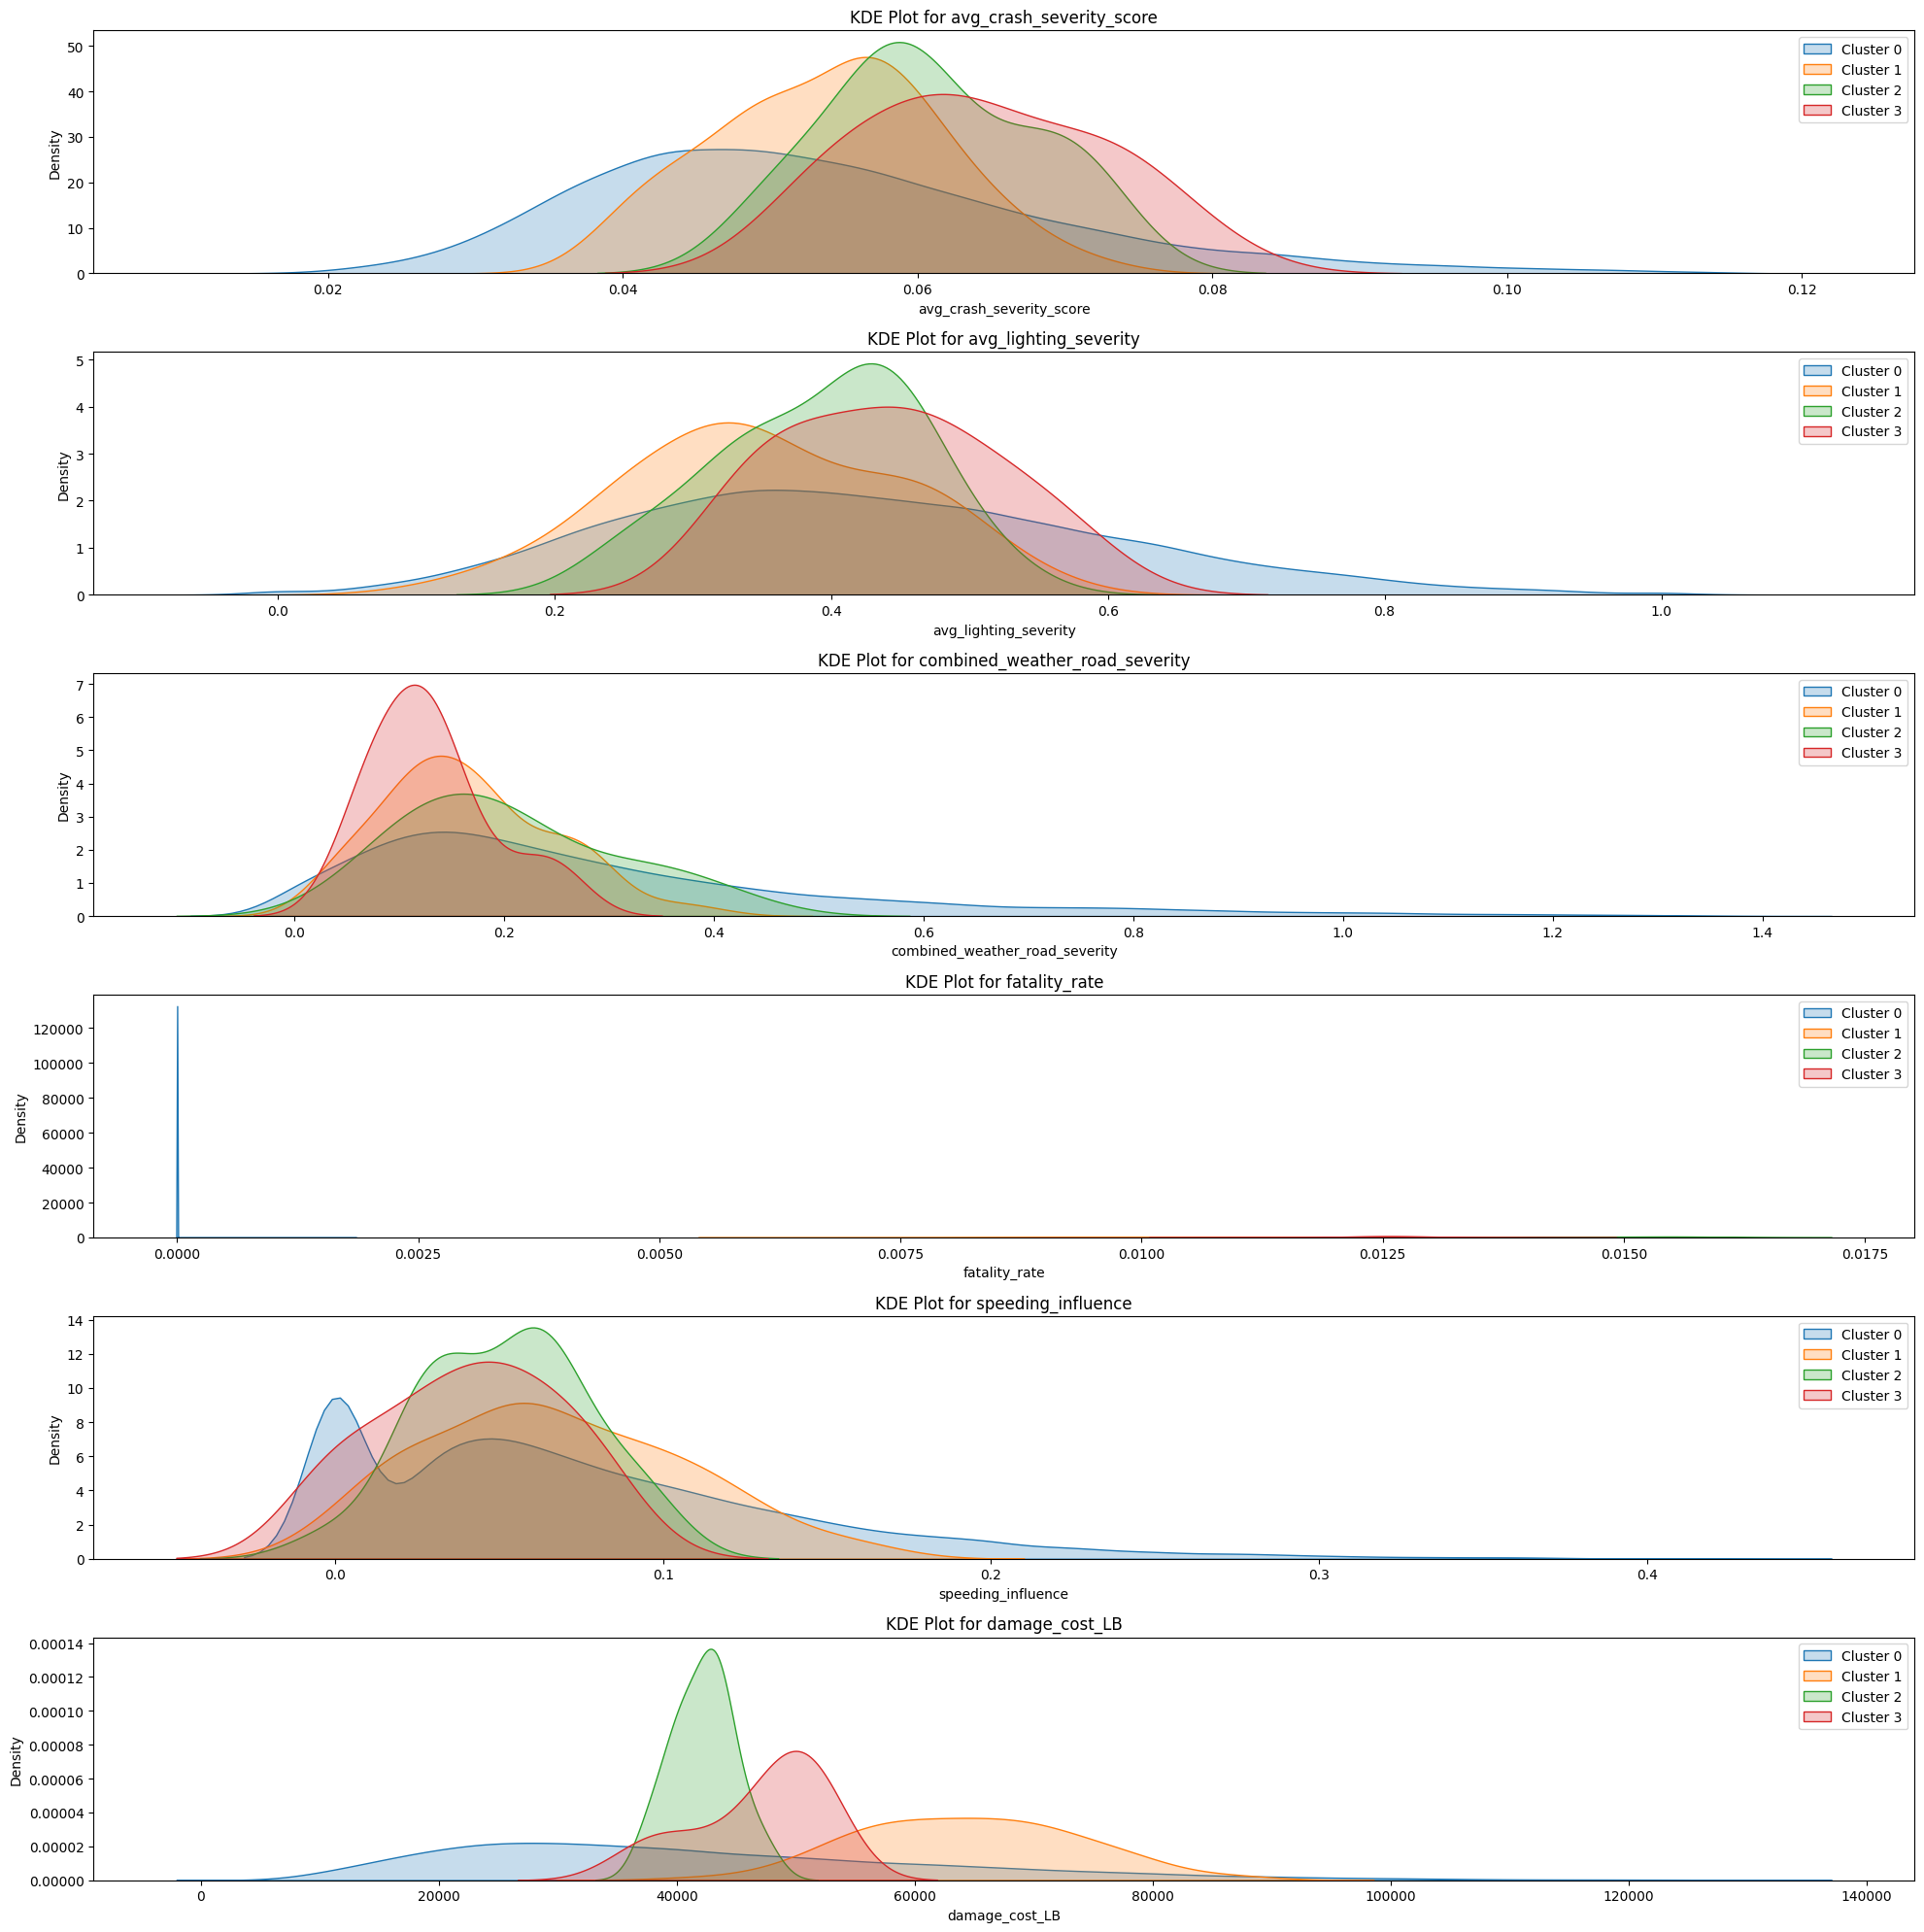

In [12]:
features = selected_features

plt.figure(figsize=(20, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    for cluster in range(len(df['cluster'].unique())):
        sns.kdeplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}', fill=True)
    plt.title(f'KDE Plot for {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

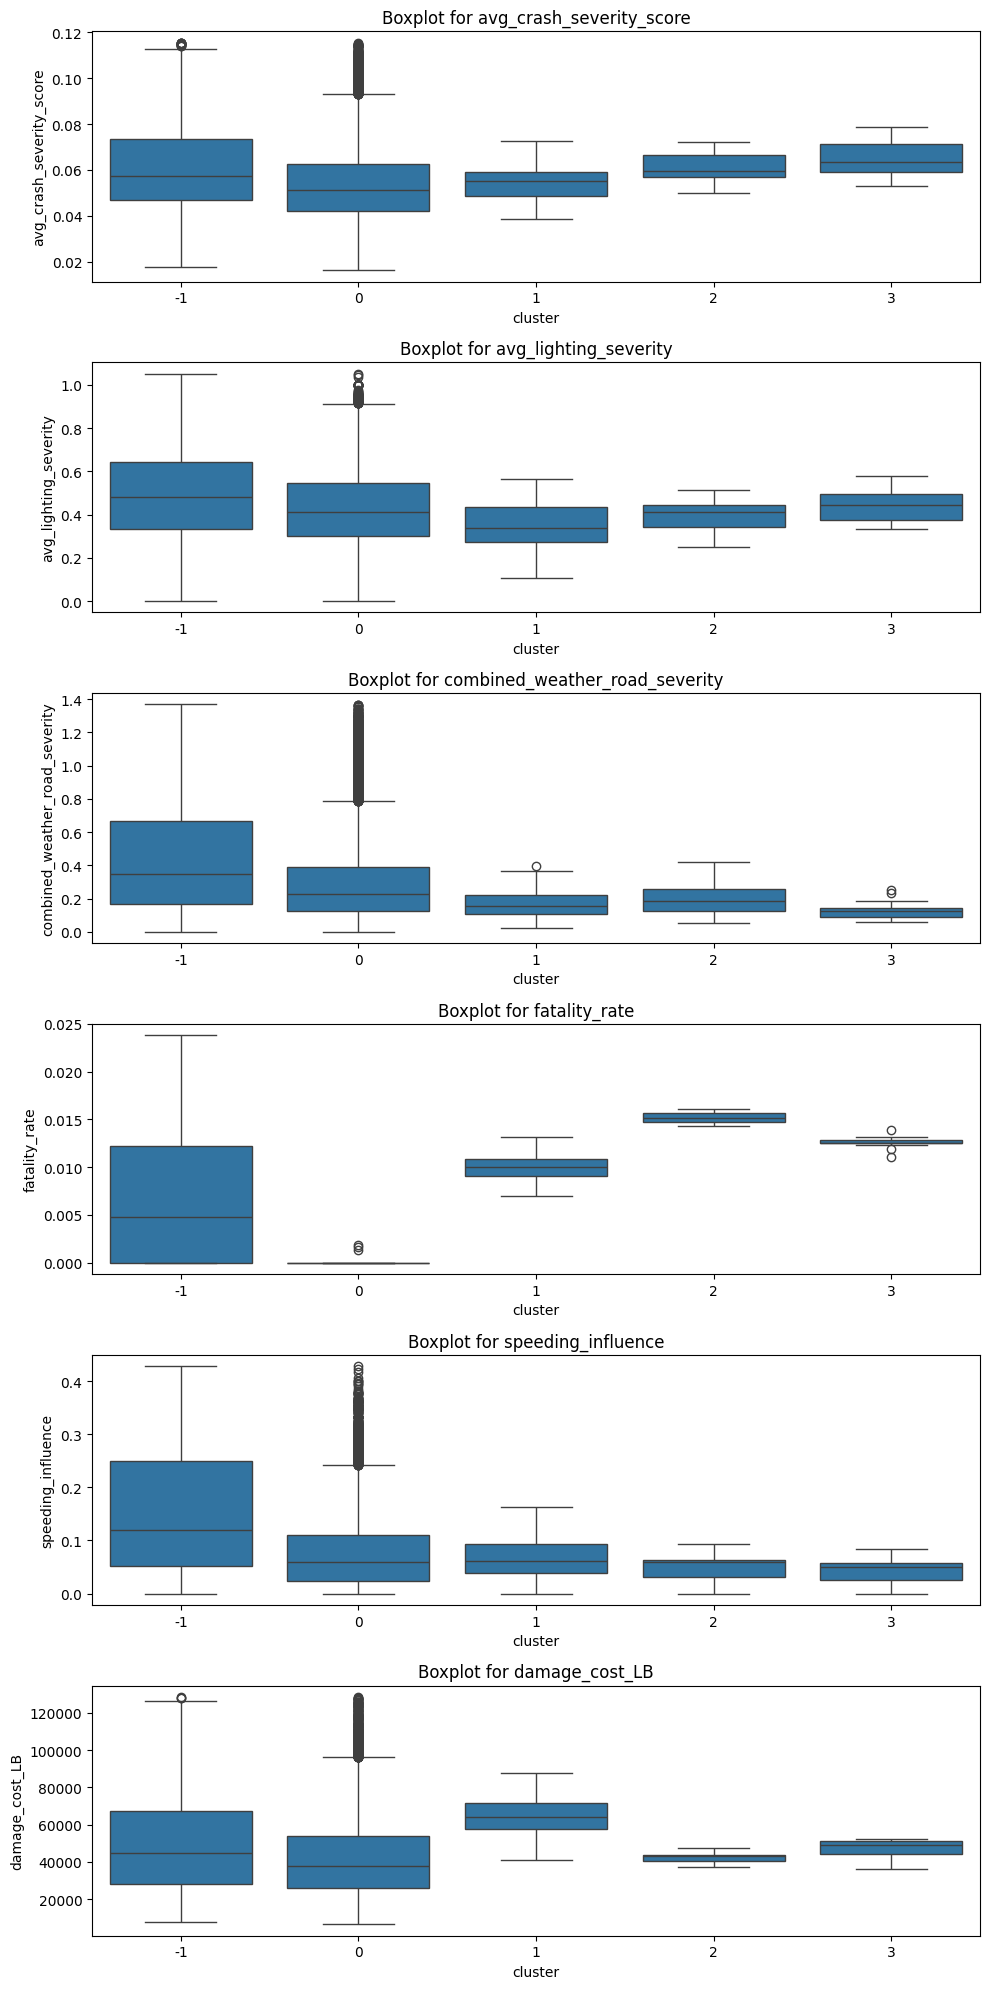

In [13]:
features = selected_features

plt.figure(figsize=(10, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()


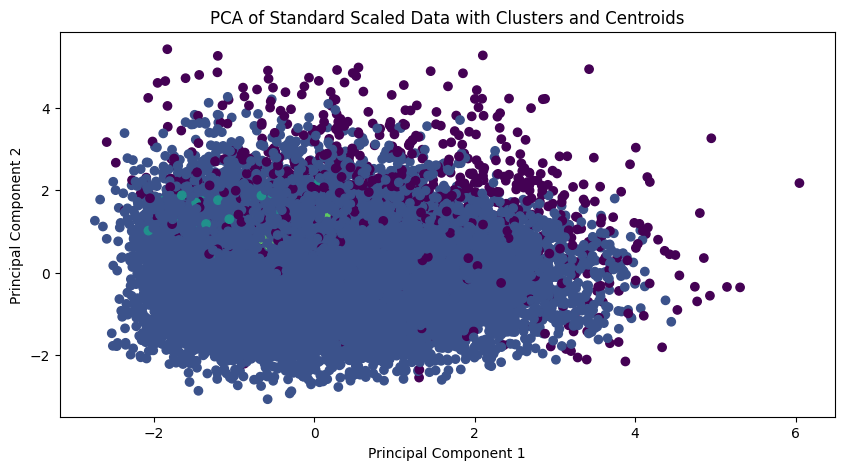

In [14]:
#pca with clusters
pca = PCA(n_components=2)
df_cluster_pca_ss = pca.fit_transform(df_cluster_ss)

plt.figure(figsize=(10, 5))
plt.scatter(df_cluster_pca_ss[:, 0], df_cluster_pca_ss[:, 1], c=labels, cmap='viridis')
plt.title('PCA of Standard Scaled Data with Clusters and Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [15]:
def clusters_pairplot(df):
    pairplot = sns.pairplot(
        df,
        hue='cluster',
        palette='Set1',
        diag_kind='kde',
        markers='o',
        plot_kws={'alpha': 0.5}
    )
    plt.legend()
    plt.show()


C:\Users\giuli\AppData\Local\Temp\ipykernel_6364\3491054098.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


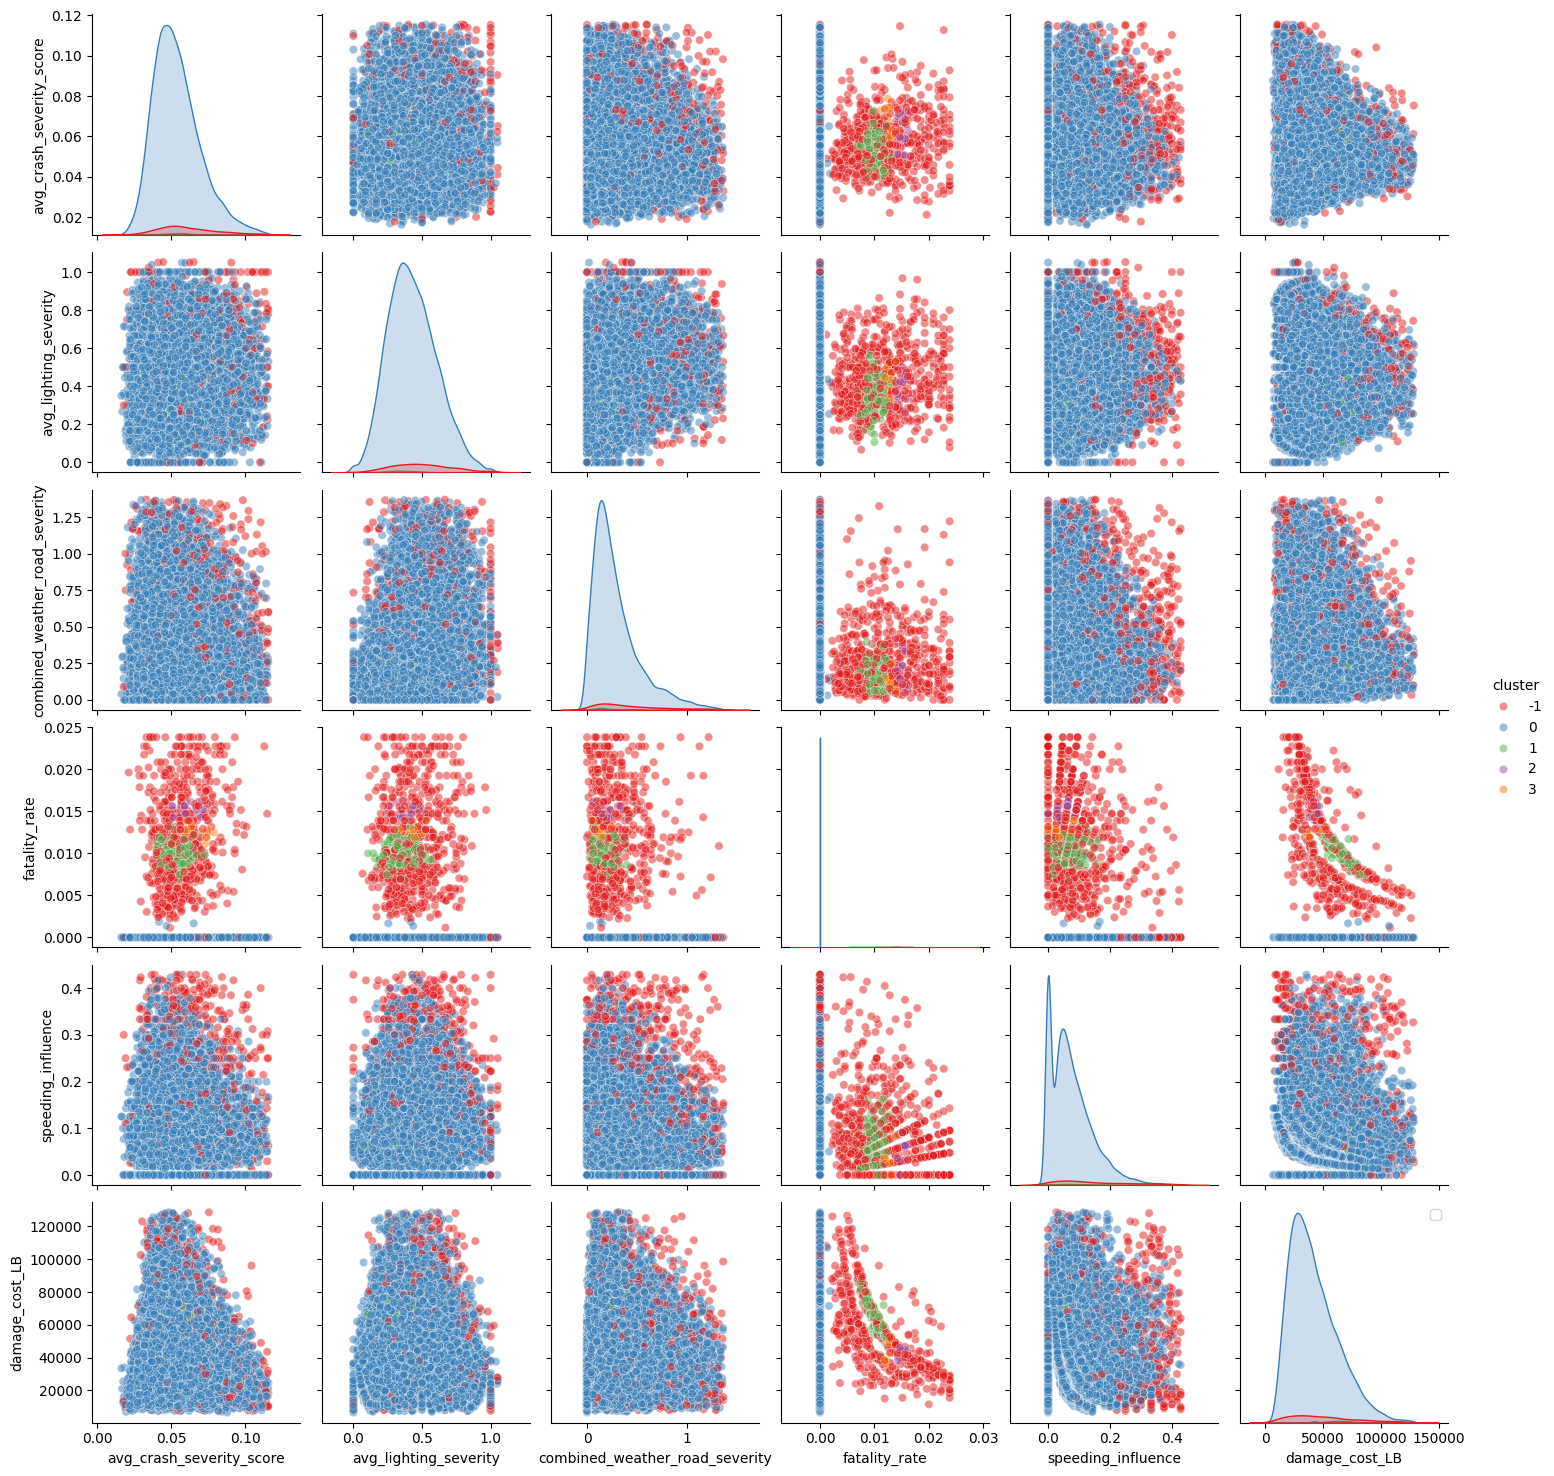

In [16]:
clusters_pairplot(df[selected_features + ['cluster']])

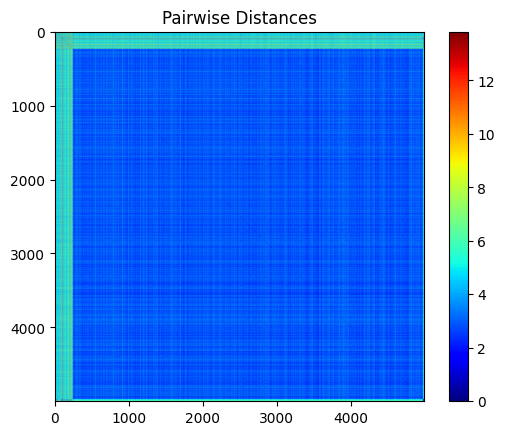

In [17]:
df_cluster_with_labels = df_cluster_ss.copy()
df_cluster_with_labels['cluster'] = labels

from sklearn.metrics import pairwise_distances
df_cluster_ss_subset = df_cluster_with_labels.sample(5000)
df_cluster_ss_subset = df_cluster_ss_subset.sort_values(by='cluster')
# compute the pairwise distances
distances = pairwise_distances(df_cluster_ss_subset[selected_features],metric='euclidean')

plt.imshow(distances, cmap ='jet')
plt.colorbar()
plt.title('Pairwise Distances')
plt.show()

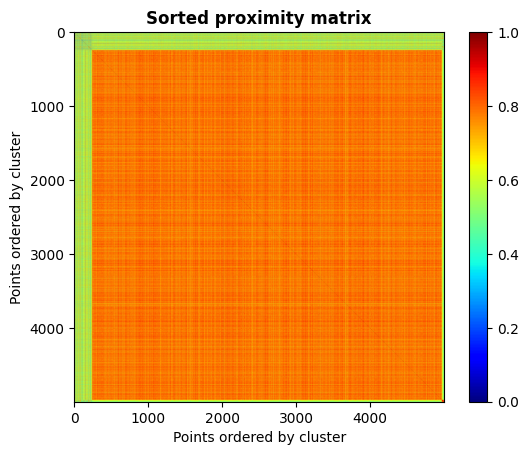

In [18]:
filtered_df = df_cluster_with_labels.sample(5000)
filtered_labels = filtered_df['cluster']
# Determine the pairwise distance matrix (using the Euclidean distance)
pairwise_distances_ = pairwise_distances(filtered_df, metric='euclidean')
# Cluster labels
n = len(filtered_labels)
# Sorting by labels
sorted_pairwisedist = pairwise_distances_[np.argsort(filtered_labels)][:, np.argsort(filtered_labels)]
# Keeping the distance values between 0 and 1.
sorted_pairwisedist = sorted_pairwisedist / np.max(sorted_pairwisedist)
sorted_similarity = 1 - sorted_pairwisedist / np.max(sorted_pairwisedist)
plt.title("Sorted proximity matrix", fontweight='bold')
plt.xlabel("Points ordered by cluster")
plt.ylabel("Points ordered by cluster")
plt.imshow(sorted_similarity, cmap='jet')
plt.colorbar()
plt.show()

In [19]:
# The optimal distance matrix has 0 if the two points are in the same cluster, 1 otherwise
optimal_distances = np.ones(distances.shape)
# locate the indices of the points in the same cluster
same_cluster_indices = np.where(
    df_cluster_ss_subset['cluster'].values.reshape(-1,1) 
    == df_cluster_ss_subset['cluster'].values.reshape(1,-1)
)
# set the optimal distance to 0
optimal_distances[same_cluster_indices] = 0

plt.imshow(optimal_distances, cmap='jet')
plt.grid(False)

In [20]:
np.corrcoef(distances.reshape(-1), optimal_distances.reshape(-1))

array([[1.        , 0.55652083],
       [0.55652083, 1.        ]])

## External features

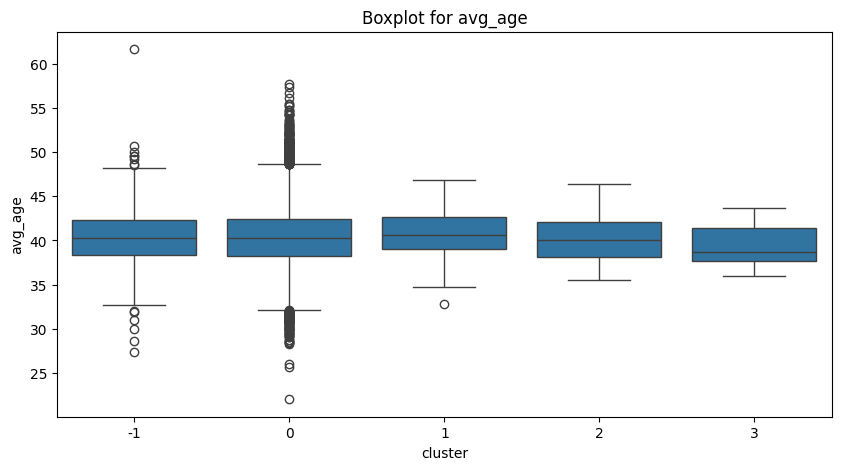

In [21]:
#boxplot with "avg_age"
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='avg_age', data=df)
plt.title('Boxplot for avg_age')
plt.show()


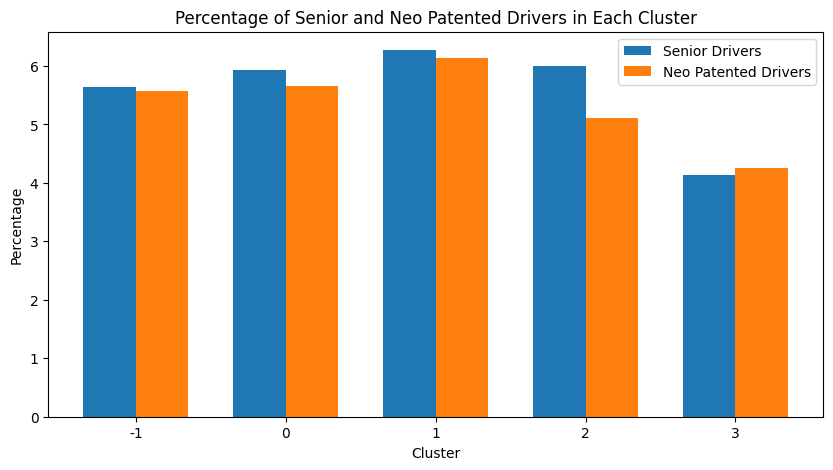

In [22]:
# Sum of senior drivers
groupped_senior = df.groupby('cluster')['senior_drivers'].sum().reset_index()
total_drivers = df.groupby('cluster')['total_drivers'].sum().reset_index()

# Percentage of senior drivers
groupped_senior = pd.merge(groupped_senior, total_drivers, on='cluster')
groupped_senior['senior_drivers_percentage'] = groupped_senior['senior_drivers'] / groupped_senior['total_drivers'] * 100

# Sum of neo patented drivers
groupped_neo = df.groupby('cluster')['neo_patented_drivers'].sum().reset_index()

# Percentage of neo patented drivers
groupped_neo = pd.merge(groupped_neo, total_drivers, on='cluster')
groupped_neo['neo_patented_drivers_percentage'] = groupped_neo['neo_patented_drivers'] / groupped_neo['total_drivers'] * 100

# Merge the dataframes
merged_df = pd.merge(groupped_senior[['cluster', 'senior_drivers_percentage']], 
                     groupped_neo[['cluster', 'neo_patented_drivers_percentage']], 
                     on='cluster')

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(merged_df))

bar1 = plt.bar(index, merged_df['senior_drivers_percentage'], bar_width, label='Senior Drivers')
bar2 = plt.bar(index + bar_width, merged_df['neo_patented_drivers_percentage'], bar_width, label='Neo Patented Drivers')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Senior and Neo Patented Drivers in Each Cluster')
plt.xticks(index + bar_width / 2, merged_df['cluster'])
plt.legend()

plt.show()


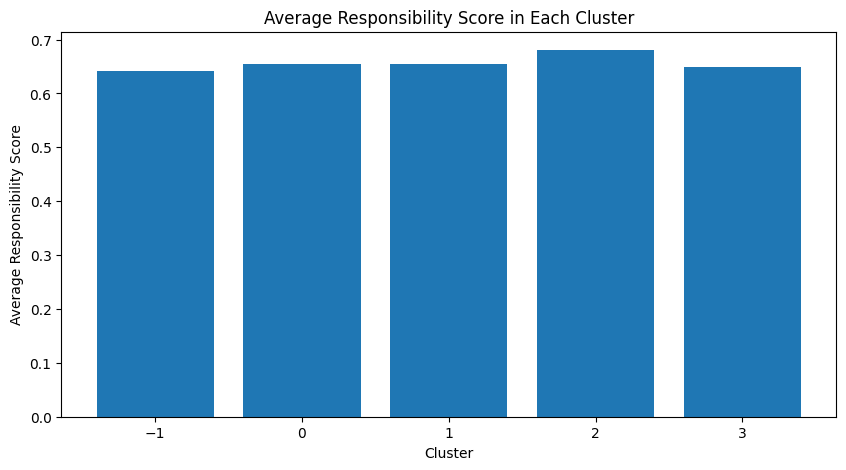

In [23]:
#mean of average_responsability_score
groupped_responsability = df.groupby('cluster')['avg_responsibility_score'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(groupped_responsability['cluster'], groupped_responsability['avg_responsibility_score'])
plt.xlabel('Cluster')
plt.ylabel('Average Responsibility Score')
plt.title('Average Responsibility Score in Each Cluster')
plt.show()


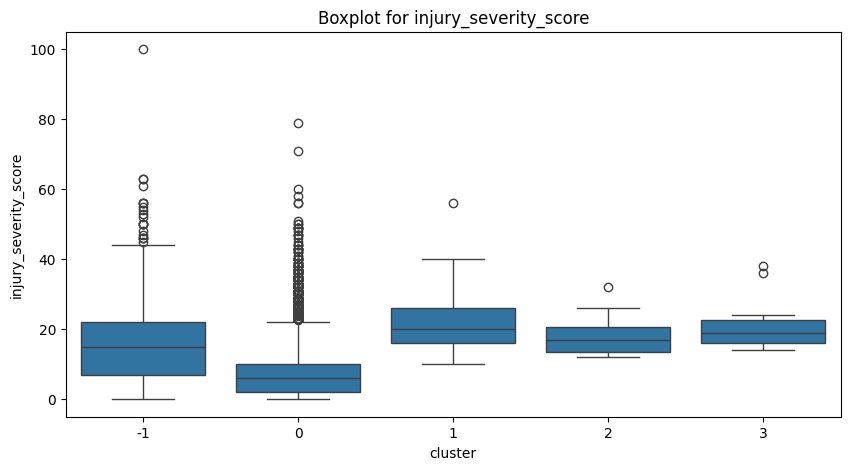

In [24]:
#box plot for injury_severity_score
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='injury_severity_score', data=df)
plt.title('Boxplot for injury_severity_score')
plt.show()


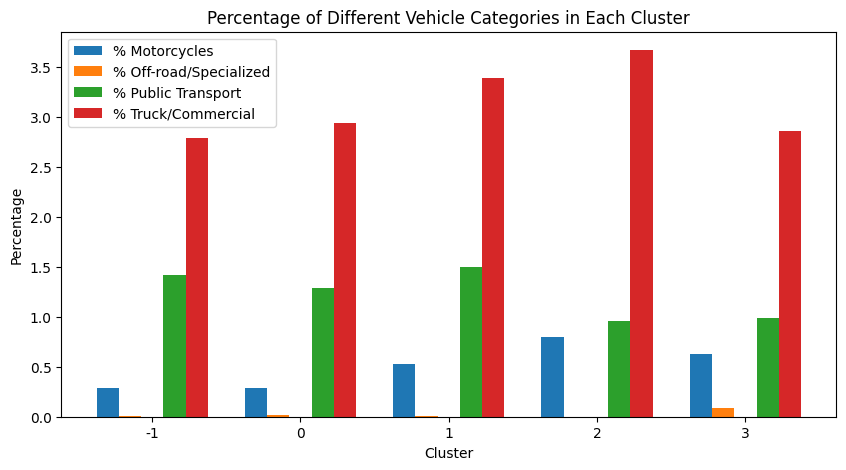

In [25]:
# Sum of motorcycles
sum_category_motorcycle = df.groupby('cluster')['sum_category_motorcycle'].sum().reset_index()
total_vehicles = df.groupby('cluster')['total_units_department'].sum().reset_index()

# Percentage of motorcycles
sum_category_motorcycle['category_motorcycle_percentage'] = sum_category_motorcycle['sum_category_motorcycle'] / total_vehicles['total_units_department'] * 100

# Sum of off-road/specialized vehicles
groupped_neo = df.groupby('cluster')['sum_category_off-road/specialized'].sum().reset_index()

# Percentage of off-road/specialized vehicles
groupped_neo['category_off-road/specialized_perc'] = groupped_neo['sum_category_off-road/specialized'] / total_vehicles['total_units_department'] * 100

# Sum of passenger vehicles
groupped_passenger = df.groupby('cluster')['sum_category_passenger vehicle'].sum().reset_index()

# Percentage of passenger vehicles
groupped_passenger['sum_category_passenger vehicle_perc'] = groupped_passenger['sum_category_passenger vehicle'] / total_vehicles['total_units_department'] * 100

# Sum of public transport vehicles
groupped_public_transport = df.groupby('cluster')['sum_category_public transport'].sum().reset_index()

# Percentage of public transport vehicles
groupped_public_transport['category_public_transport_perc'] = groupped_public_transport['sum_category_public transport'] / total_vehicles['total_units_department'] * 100

# Sum of truck/commercial vehicles
groupped_truck_commercial = df.groupby('cluster')['sum_category_truck/commercial'].sum().reset_index()

# Percentage of truck/commercial vehicles
groupped_truck_commercial['category_truck_commercial_perc'] = groupped_truck_commercial['sum_category_truck/commercial'] / total_vehicles['total_units_department'] * 100

# Merge the dataframes
merged_df = pd.merge(sum_category_motorcycle[['cluster', 'category_motorcycle_percentage']], 
                     groupped_neo[['cluster', 'category_off-road/specialized_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_passenger[['cluster', 'sum_category_passenger vehicle_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_public_transport[['cluster', 'category_public_transport_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_truck_commercial[['cluster', 'category_truck_commercial_perc']], 
                     on='cluster')

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.15
index = np.arange(len(merged_df))

bar1 = plt.bar(index, merged_df['category_motorcycle_percentage'], bar_width, label='% Motorcycles')
bar2 = plt.bar(index + bar_width, merged_df['category_off-road/specialized_perc'], bar_width, label="% Off-road/Specialized")
#bar3 = plt.bar(index + 2 * bar_width, merged_df['sum_category_passenger vehicle_perc'], bar_width, label="% Passenger")
bar4 = plt.bar(index + 3 * bar_width, merged_df['category_public_transport_perc'], bar_width, label="% Public Transport")
bar5 = plt.bar(index + 4 * bar_width, merged_df['category_truck_commercial_perc'], bar_width, label="% Truck/Commercial")

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Different Vehicle Categories in Each Cluster')
plt.xticks(index + 2 * bar_width, merged_df['cluster'])
plt.legend()

plt.show()

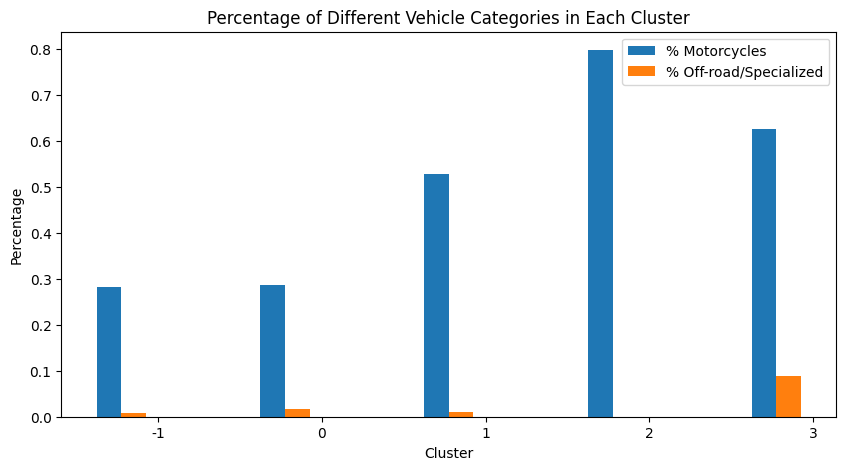

In [26]:
# Sum of motorcycles
sum_category_motorcycle = df.groupby('cluster')['sum_category_motorcycle'].sum().reset_index()
total_vehicles = df.groupby('cluster')['total_units_department'].sum().reset_index()

# Percentage of motorcycles
sum_category_motorcycle['category_motorcycle_percentage'] = sum_category_motorcycle['sum_category_motorcycle'] / total_vehicles['total_units_department'] * 100

# Sum of off-road/specialized vehicles
groupped_neo = df.groupby('cluster')['sum_category_off-road/specialized'].sum().reset_index()

# Percentage of off-road/specialized vehicles
groupped_neo['category_off-road/specialized_perc'] = groupped_neo['sum_category_off-road/specialized'] / total_vehicles['total_units_department'] * 100

# Sum of passenger vehicles
groupped_passenger = df.groupby('cluster')['sum_category_passenger vehicle'].sum().reset_index()

# Percentage of passenger vehicles
groupped_passenger['sum_category_passenger vehicle_perc'] = groupped_passenger['sum_category_passenger vehicle'] / total_vehicles['total_units_department'] * 100

# Sum of public transport vehicles
groupped_public_transport = df.groupby('cluster')['sum_category_public transport'].sum().reset_index()

# Percentage of public transport vehicles
groupped_public_transport['category_public_transport_perc'] = groupped_public_transport['sum_category_public transport'] / total_vehicles['total_units_department'] * 100

# Sum of truck/commercial vehicles
groupped_truck_commercial = df.groupby('cluster')['sum_category_truck/commercial'].sum().reset_index()

# Percentage of truck/commercial vehicles
groupped_truck_commercial['category_truck_commercial_perc'] = groupped_truck_commercial['sum_category_truck/commercial'] / total_vehicles['total_units_department'] * 100

# Merge the dataframes
merged_df = pd.merge(sum_category_motorcycle[['cluster', 'category_motorcycle_percentage']], 
                     groupped_neo[['cluster', 'category_off-road/specialized_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_passenger[['cluster', 'sum_category_passenger vehicle_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_public_transport[['cluster', 'category_public_transport_perc']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_truck_commercial[['cluster', 'category_truck_commercial_perc']], 
                     on='cluster')

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.15
index = np.arange(len(merged_df))

bar1 = plt.bar(index, merged_df['category_motorcycle_percentage'], bar_width, label='% Motorcycles')
bar2 = plt.bar(index + bar_width, merged_df['category_off-road/specialized_perc'], bar_width, label="% Off-road/Specialized")
#bar3 = plt.bar(index + 2 * bar_width, merged_df['sum_category_passenger vehicle_perc'], bar_width, label="% Passenger")
#bar4 = plt.bar(index + 3 * bar_width, merged_df['category_public_transport_perc'], bar_width, label="% Public Transport")
#bar5 = plt.bar(index + 4 * bar_width, merged_df['category_truck_commercial_perc'], bar_width, label="% Truck/Commercial")

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Different Vehicle Categories in Each Cluster')
plt.xticks(index + 2 * bar_width, merged_df['cluster'])
plt.legend()

plt.show()

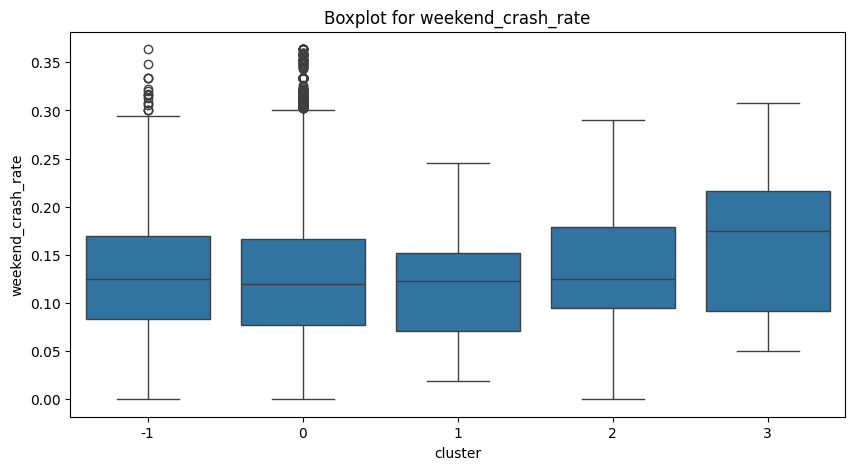

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='weekend_crash_rate', data=df)
plt.title('Boxplot for weekend_crash_rate')
plt.show()

In [28]:
features_to_test = [
 'road_defect_crash_rate',
 'num_towed_units_LB',
 'vehicle_involvement_rate',
 'night_crash_rate',
 'injury_severity_score',
 'weekend_crash_rate',
 'avg_weather_severity',
 'severe_injury_rate',
 'adverse_weather_crash_rate',
 'avg_roadway_severity']

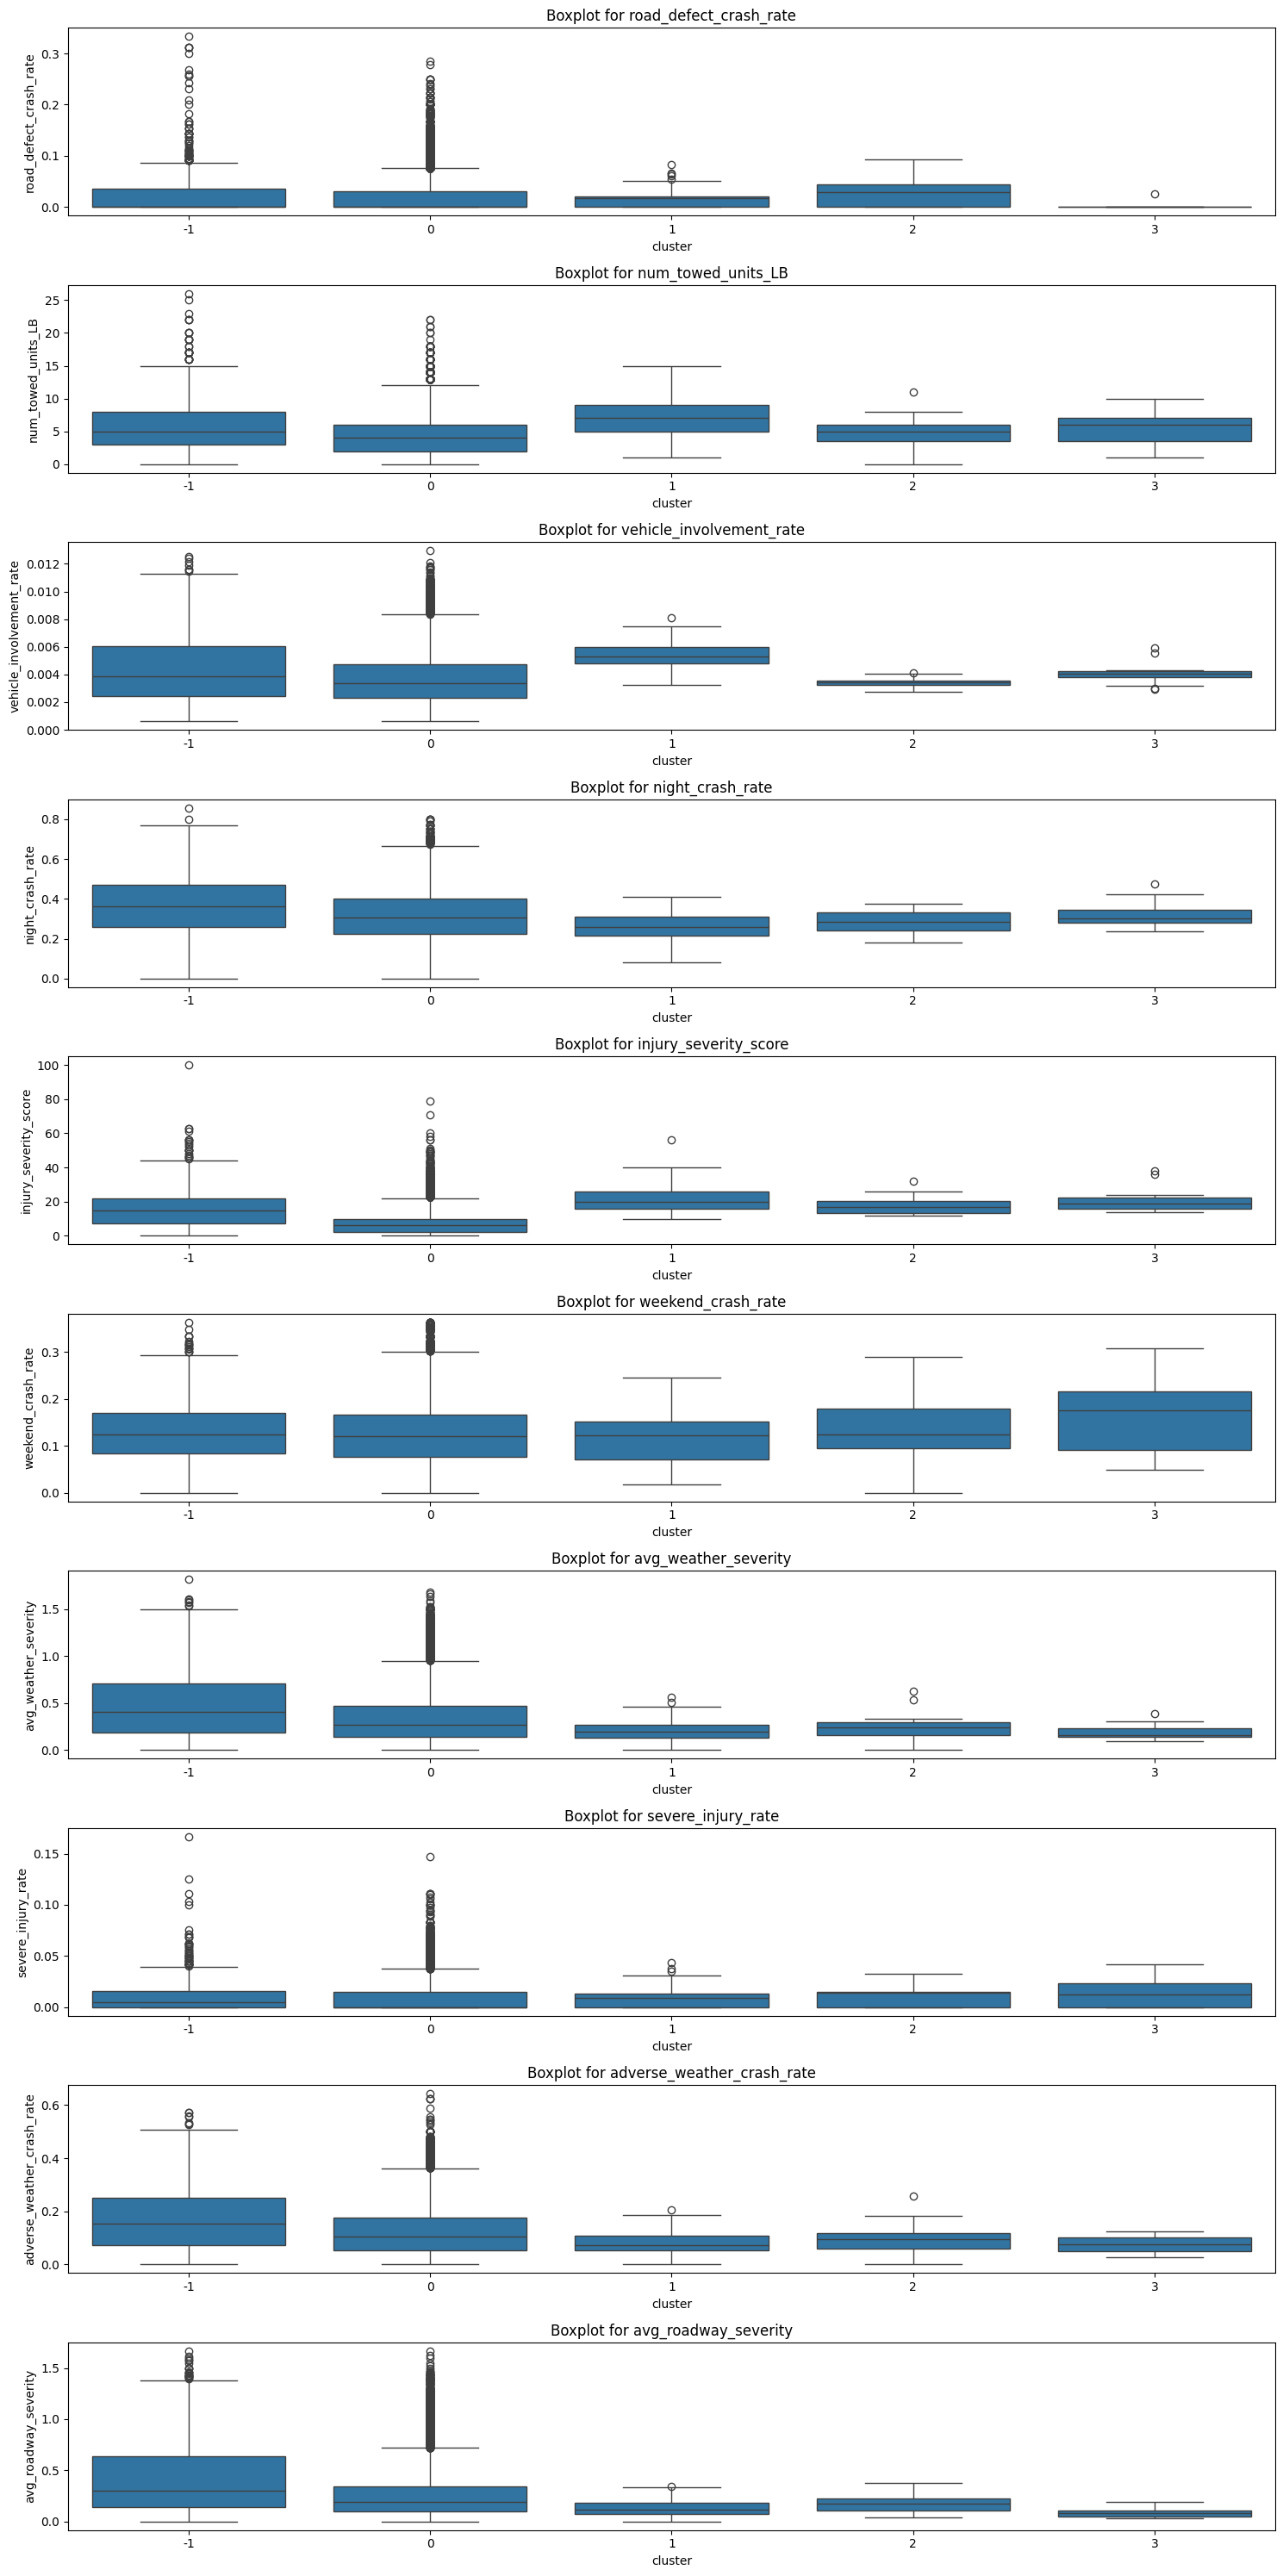

In [29]:
#box plots for all the validation_features
plt.figure(figsize=(15, 30))
for i, feature in enumerate(features_to_test):
    plt.subplot(len(features_to_test), 1, i+1)
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()


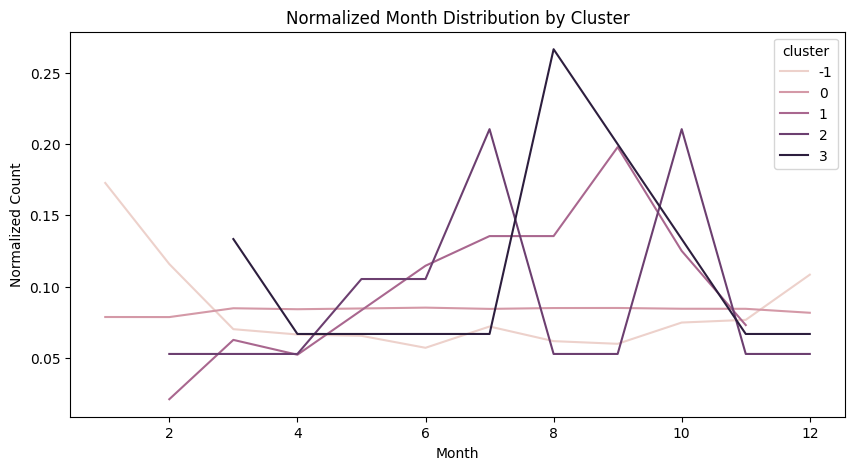

In [30]:
# Month distribution by cluster
month_df = df.groupby(['cluster', 'CRASH_MONTH']).size().reset_index(name='count')

# Normalize by the number of elements in each cluster
cluster_sizes = df['cluster'].value_counts().sort_index()
month_df['normalized_count'] = month_df.apply(lambda row: row['count'] / cluster_sizes[row['cluster']], axis=1)

plt.figure(figsize=(10, 5))
sns.lineplot(x='CRASH_MONTH', y='normalized_count', hue='cluster', data=month_df)
plt.title('Normalized Month Distribution by Cluster')
plt.xlabel('Month')
plt.ylabel('Normalized Count')
plt.show()

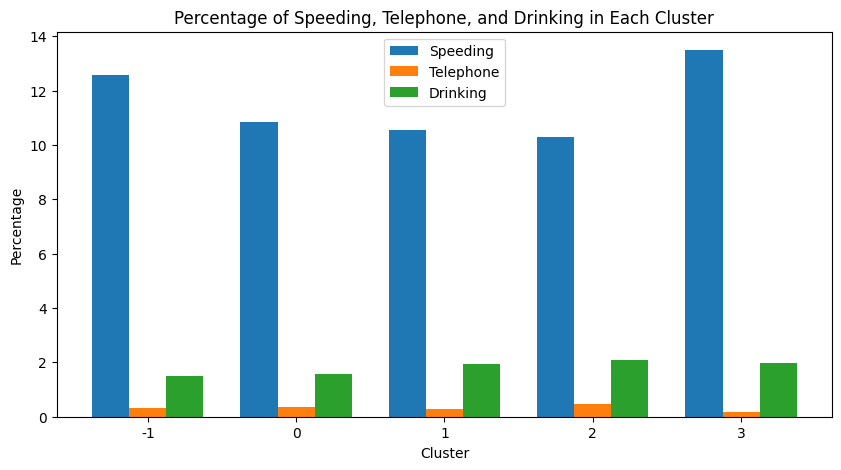

In [31]:
# Sum of speeding
groupped_speeding = df.groupby('cluster')['sum_speeding'].sum().reset_index()
total_crashes = df.groupby('cluster')['total_crashes'].sum().reset_index()

# Percentage of speeding
groupped_speeding = pd.merge(groupped_speeding, total_crashes, on='cluster')
groupped_speeding['speeding_percentage'] = groupped_speeding['sum_speeding'] / groupped_speeding['total_crashes'] * 100

# Sum of telephone
groupped_telephone = df.groupby('cluster')['sum_telephone'].sum().reset_index()

# Percentage of telephone
groupped_telephone = pd.merge(groupped_telephone, total_crashes, on='cluster')
groupped_telephone['telephone_percentage'] = groupped_telephone['sum_telephone'] / groupped_telephone['total_crashes'] * 100

# Sum of drinking
groupped_drinking = df.groupby('cluster')['sum_drinking'].sum().reset_index()

# Percentage of drinking
groupped_drinking = pd.merge(groupped_drinking, total_crashes, on='cluster')
groupped_drinking['drinking_percentage'] = groupped_drinking['sum_drinking'] / groupped_drinking['total_crashes'] * 100

# Merge the dataframes
merged_df = pd.merge(groupped_speeding[['cluster', 'speeding_percentage']], 
                     groupped_telephone[['cluster', 'telephone_percentage']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_drinking[['cluster', 'drinking_percentage']], 
                     on='cluster')

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(merged_df))

bar1 = plt.bar(index, merged_df['speeding_percentage'], bar_width, label='Speeding')
bar2 = plt.bar(index + bar_width, merged_df['telephone_percentage'], bar_width, label='Telephone')
bar3 = plt.bar(index + 2 * bar_width, merged_df['drinking_percentage'], bar_width, label='Drinking')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Speeding, Telephone, and Drinking in Each Cluster')
plt.xticks(index + bar_width, merged_df['cluster'])
plt.legend()

plt.show()

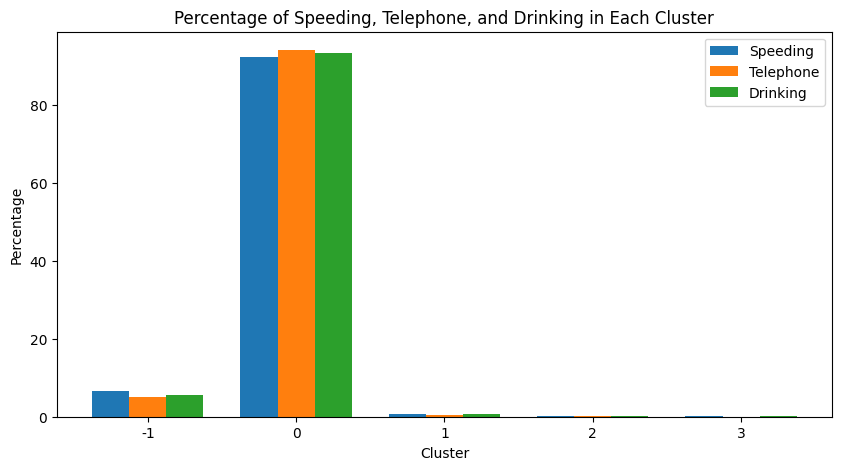

In [32]:
speed_total = df['sum_speeding'].sum()
speed_total

telephone_total = df['sum_telephone'].sum()
telephone_total

drinking_total = df['sum_drinking'].sum()
drinking_total

# Sum of speeding
groupped_speeding = df.groupby('cluster')['sum_speeding'].sum().reset_index()
total_crashes = df.groupby('cluster')['total_crashes'].sum().reset_index()

# Percentage of speeding
groupped_speeding = pd.merge(groupped_speeding, total_crashes, on='cluster')
groupped_speeding['speeding_percentage'] = groupped_speeding['sum_speeding'] / speed_total * 100

# Sum of telephone
groupped_telephone = df.groupby('cluster')['sum_telephone'].sum().reset_index()

# Percentage of telephone
groupped_telephone = pd.merge(groupped_telephone, total_crashes, on='cluster')
groupped_telephone['telephone_percentage'] = groupped_telephone['sum_telephone'] / telephone_total * 100

# Sum of drinking
groupped_drinking = df.groupby('cluster')['sum_drinking'].sum().reset_index()

# Percentage of drinking
groupped_drinking = pd.merge(groupped_drinking, total_crashes, on='cluster')
groupped_drinking['drinking_percentage'] = groupped_drinking['sum_drinking'] / drinking_total * 100

# Merge the dataframes
merged_df = pd.merge(groupped_speeding[['cluster', 'speeding_percentage']], 
                     groupped_telephone[['cluster', 'telephone_percentage']], 
                     on='cluster')
merged_df = pd.merge(merged_df, 
                     groupped_drinking[['cluster', 'drinking_percentage']], 
                     on='cluster')

# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(merged_df))

bar1 = plt.bar(index, merged_df['speeding_percentage'], bar_width, label='Speeding')
bar2 = plt.bar(index + bar_width, merged_df['telephone_percentage'], bar_width, label='Telephone')
bar3 = plt.bar(index + 2 * bar_width, merged_df['drinking_percentage'], bar_width, label='Drinking')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Speeding, Telephone, and Drinking in Each Cluster')
plt.xticks(index + bar_width, merged_df['cluster'])
plt.legend()

plt.show()

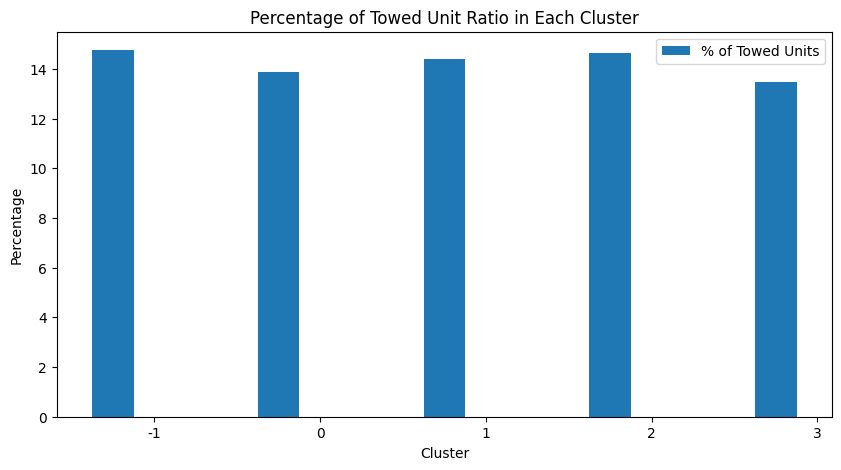

In [33]:
# % towed_unit_ratio
groupped_towed_unit_ratio = df.groupby('cluster')['num_towed_units_LB'].sum().reset_index()
total_crashes = df.groupby('cluster')['total_crashes'].sum().reset_index()

groupped_towed_unit_ratio['towed_unit_perc'] = groupped_towed_unit_ratio['num_towed_units_LB'] / total_crashes['total_crashes'] * 100

#plot
plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(groupped_towed_unit_ratio))

bar1 = plt.bar(index, groupped_towed_unit_ratio['towed_unit_perc'], bar_width, label='% of Towed Units')

plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Towed Unit Ratio in Each Cluster')
plt.xticks(index + bar_width, groupped_towed_unit_ratio['cluster'])
plt.legend()

                     



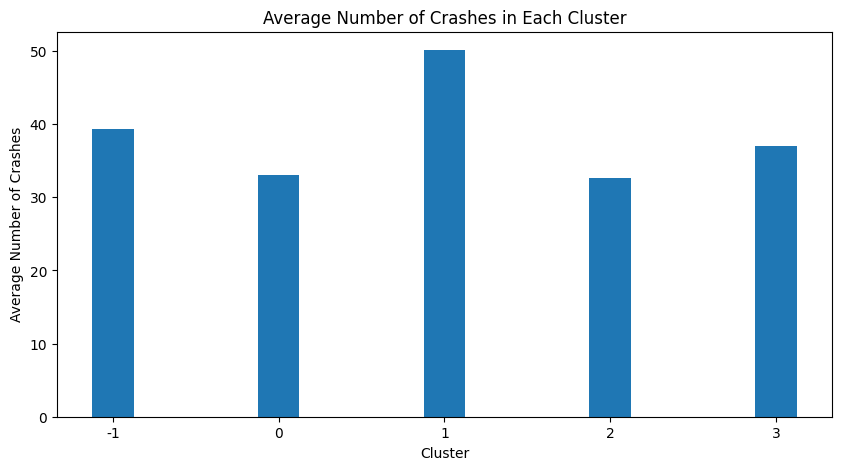

In [34]:
#avg number of crashes by cluster
groupped_crashes = df.groupby('cluster')['total_crashes'].mean().reset_index()

#plot
plt.figure(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(groupped_crashes))

bar1 = plt.bar(index, groupped_crashes['total_crashes'], bar_width, label='Average Number of Crashes')

plt.xlabel('Cluster')
plt.ylabel('Average Number of Crashes')
plt.title('Average Number of Crashes in Each Cluster')
plt.xticks(index, groupped_crashes['cluster'])

plt.show()

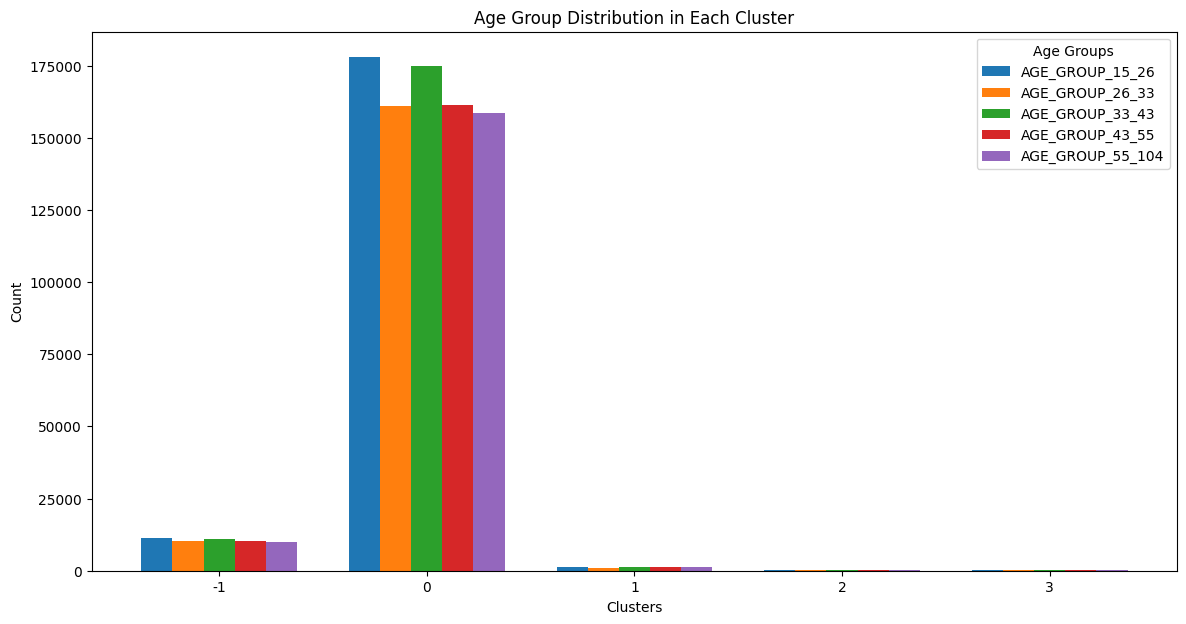

In [35]:
age_features = ['AGE_GROUP_15_26', 'AGE_GROUP_26_33', 'AGE_GROUP_33_43', 'AGE_GROUP_43_55', 'AGE_GROUP_55_104']

# Group by cluster and age group
df_age = df.groupby('cluster')[age_features].sum().reset_index()

# Transpose the dataframe
df_age_transposed = df_age.set_index('cluster').T

# Bar plot for each age group
bar_width = 0.15
index = np.arange(len(df_age_transposed.columns))

plt.figure(figsize=(14, 7))
for i, age_group in enumerate(df_age_transposed.index):
    plt.bar(index + i * bar_width, df_age_transposed.iloc[i], bar_width, label=age_group)

plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Age Group Distribution in Each Cluster')
plt.xticks(index + bar_width * (len(df_age_transposed.index) - 1) / 2, df_age_transposed.columns)
plt.legend(title='Age Groups')
plt.show()

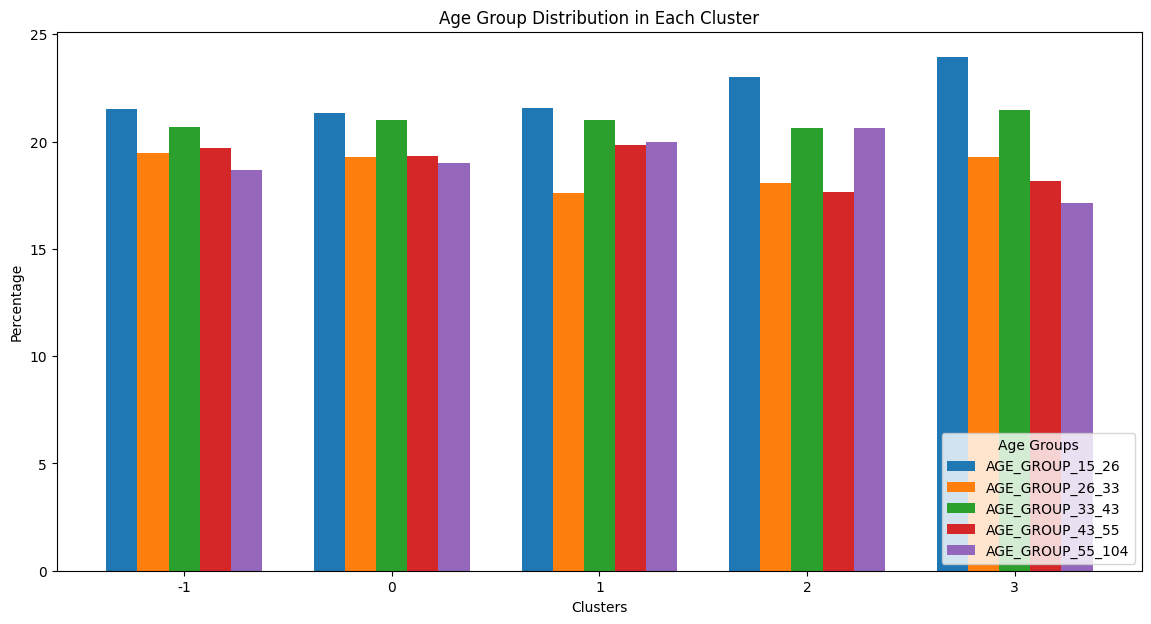

In [36]:
# Calculate the total number of elements in each cluster
cluster_sizes = df_age.set_index('cluster').sum(axis=1)

# Calculate the percentage of each age group with respect to the size of each cluster
df_age_percentage = df_age.set_index('cluster').div(cluster_sizes, axis=0) * 100

# Transpose the dataframe for plotting
df_age_percentage_transposed = df_age_percentage.T

# Bar plot for each age group
bar_width = 0.15
index = np.arange(len(df_age_percentage_transposed.columns))

plt.figure(figsize=(14, 7))
for i, age_group in enumerate(df_age_percentage_transposed.index):
    plt.bar(index + i * bar_width, df_age_percentage_transposed.iloc[i], bar_width, label=age_group)

plt.xlabel('Clusters')
plt.ylabel('Percentage')
plt.title('Age Group Distribution in Each Cluster')
plt.xticks(index + bar_width * (len(df_age_percentage_transposed.index) - 1) / 2, df_age_percentage_transposed.columns)
plt.legend(title='Age Groups', loc='lower right')
plt.show()

In [37]:
# divide the pct_neo_patented_drivers into 4 groups
df['pct_neo_patented_drivers_group'] = pd.qcut(df['pct_neo_patented_drivers'], 2)
df['pct_neo_patented_drivers_group'].value_counts()
# show the range for each group
df.groupby('pct_neo_patented_drivers_group')['pct_neo_patented_drivers'].describe()

C:\Users\giuli\AppData\Local\Temp\ipykernel_6364\1277552400.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('pct_neo_patented_drivers_group')['pct_neo_patented_drivers'].describe()


count      mean       std      min  \
pct_neo_patented_drivers_group                                         
(-0.001, 0.0508]                10870.0  0.025266  0.017073  0.00000   
(0.0508, 0.182]                 10820.0  0.082932  0.026122  0.05102   

                                     25%       50%       75%       max  
pct_neo_patented_drivers_group                                          
(-0.001, 0.0508]                0.010417  0.028571  0.040000  0.050847  
(0.0508, 0.182]                 0.062500  0.076923  0.096774  0.181818

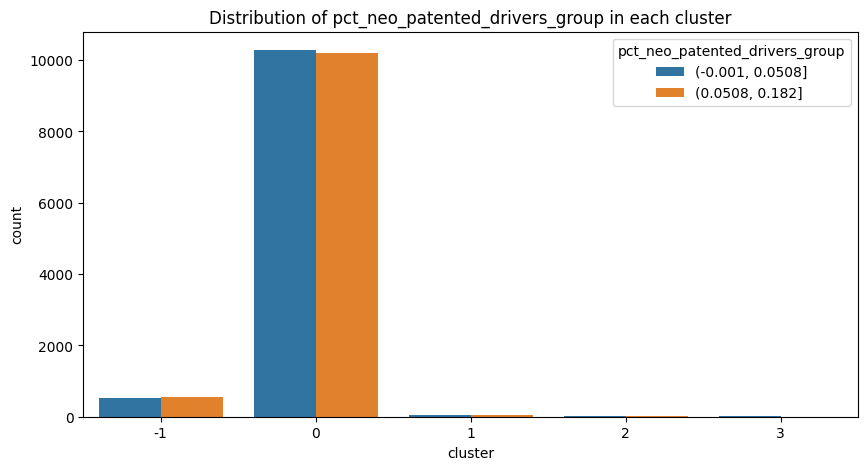

In [38]:
# check the distribution of pct_neo_patented_drivers_group in each cluster
plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', hue='pct_neo_patented_drivers_group', data=df)
plt.title('Distribution of pct_neo_patented_drivers_group in each cluster')
plt.show()


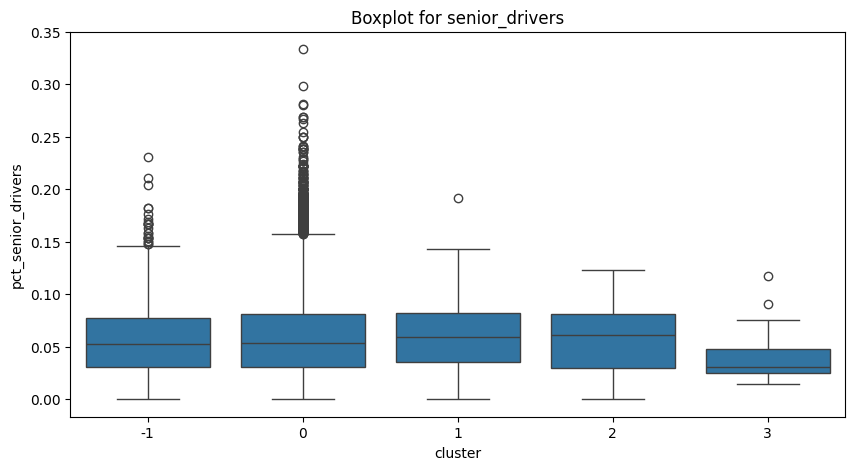

In [39]:
# the same for pct_senior_drivers
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='pct_senior_drivers', data=df)
plt.title('Boxplot for senior_drivers')
plt.show()



C:\Users\giuli\AppData\Local\Temp\ipykernel_6364\2560683497.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('pct_senior_drivers_group')['pct_senior_drivers'].describe()


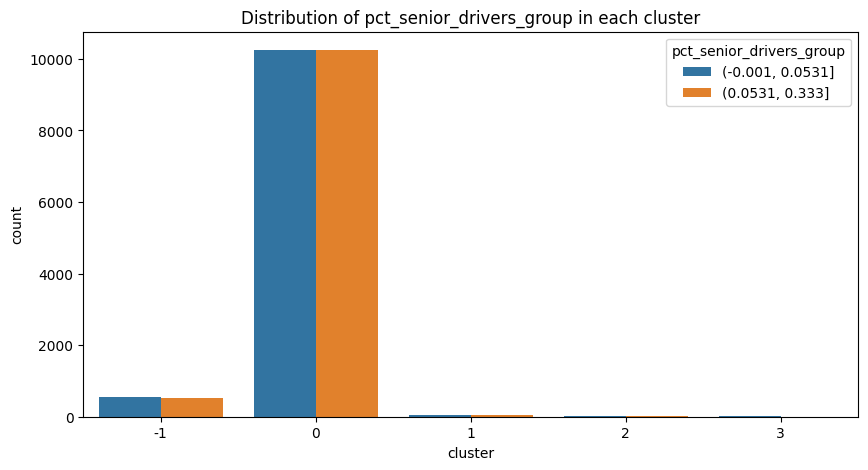

In [40]:

df['pct_senior_drivers_group'] = pd.qcut(df['pct_senior_drivers'], 2)
df['pct_senior_drivers_group'].value_counts()
df.groupby('pct_senior_drivers_group')['pct_senior_drivers'].describe()

plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', hue='pct_senior_drivers_group', data=df)
plt.title('Distribution of pct_senior_drivers_group in each cluster')
plt.show()



# Cluster Characterization

Using a high number of min_points DBSCAN was giving 2 big cluster (considering the one labeled -1 that are the outliers). With a lower number of min_points more than 2 clusters were formed but with not so many elements, the found clusters are the following:

Cluster 0 (20489 Elements):
The cluster with almost all the elements, it didn't capture much information.

Cluster 1 (96 Elements):
In this cluster there is the highest number of average number of crash and as well the highest damage and more vehicles were involved in the crashes. It may represent crashes that are considered expansive. 

Cluster 2 (19 Elements): 
There are more young drivers and it has the highest fatality rate. It probably rapresent incident that can have one or more fatality, motocycles are higher in percentage with respect to the other clusters.

Cluster 3 (15 Elements): 
In this cluster there are less senior drivers and more young drivers w.r.t the other clusters. The highest percentage of crashes where speeding is the main reason of the crash. It can represent the fact that young drivers tend to crash because of speeding.

Cluster -1 (1071 Elements):
